<a href="https://colab.research.google.com/github/chipsalliance/silicon-notebooks/blob/main/digital-inverter-openlane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digital inverter with OpenLane

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Run a simple digital inverter design thru the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) GDS to RTL flow targeting the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

## Install dependencies

In [9]:
import os
import pathlib
import sys

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
print(CONDA_PREFIX)
if not CONDA_PREFIX:
    !curl -O https://repo.anaconda.com/miniconda/Miniconda3-py37_4.12.0-Linux-x86_64.sh
    !bash Miniconda3-py37_4.12.0-Linux-x86_64.sh -p conda-env -b
    conda_prefix_path = pathlib.Path('conda-env')
    site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
    sys.path.insert(0, str(site_package_path.resolve()))
    CONDA_PREFIX = str(conda_prefix_path.resolve())
    PATH = os.environ['PATH']
    LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
    %env CONDA_PREFIX={CONDA_PREFIX}
    %env PATH={CONDA_PREFIX}/bin:{PATH}
    %env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}

In [1]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - openroad
  - netgen
  - yosys
  - gdstk
  - tcllib
  - python
  - pip
  - pip:
    - pyyaml
    - click
    - pandas

In [ ]:
!conda env update --prefix $CONDA_PREFIX --file environment.yml

## Get OpenLane

In [4]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane

## Write verilog

In [5]:
%%writefile inverter.v
module inverter(input wire in, output wire out);
    assign out = !in;
endmodule

## Write configuration

In [13]:
%%writefile config.tcl
set ::env(DESIGN_NAME) inverter

set script_dir [file dirname [file normalize [info script]]]
set ::env(VERILOG_FILES) "$script_dir/inverter.v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""

set ::env(PL_RANDOM_GLB_PLACEMENT) 1

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 50 50"
set ::env(PL_TARGET_DENSITY) 0.80


set ::env(FP_PDN_HORIZONTAL_HALO) 6
set ::env(FP_PDN_VERTICAL_HALO) 6

set ::env(DIODE_INSERTION_STRATEGY) 3

# disable version checks because we use conda packaged versions
set ::env(TEST_MISMATCHES) none
# disable klayout because of https://github.com/hdl/conda-eda/issues/175
set ::env(RUN_KLAYOUT) 0
# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

Overwriting config.tcl


## Run OpenLane Flow

In [14]:
import os
import pathlib
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design .

env: PDK_ROOT=/home/proppy/src/github.com/chipsalliance/silicon-notebooks/conda-env/share/pdk
env: TCLLIBPATH=/home/proppy/src/github.com/chipsalliance/silicon-notebooks/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/home/proppy/src/github.com/chipsalliance/silicon-notebooks/OpenLane
env: PATH=/home/proppy/src/github.com/chipsalliance/silicon-notebooks/conda-env/bin:/home/proppy/src/github.com/chipsalliance/silicon-notebooks/conda-env/condabin:/home/proppy/riscv64-unknown-elf-gcc-8.3.0-2020.04.1-x86_64-linux-ubuntu14/bin:/home/proppy/fomu-toolchain-Linux/bin:/home/proppy/riscv64-unknown-elf-gcc-8.3.0-2020.04.1-x86_64-linux-ubuntu14/bin:/home/proppy/fomu-toolchain-Linux/bin:/home/proppy/bin:/home/proppy/.cargo/bin:/home/proppy/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/proppy/src/github.com/chipsalliance/silicon-notebooks/OpenLane:/home/proppy/src/github.com/chipsalliance/silicon-notebooks/OpenLane/scripts:/home/proppy/src/github.com/chipsalliance/silicon-noteb

## Display layout

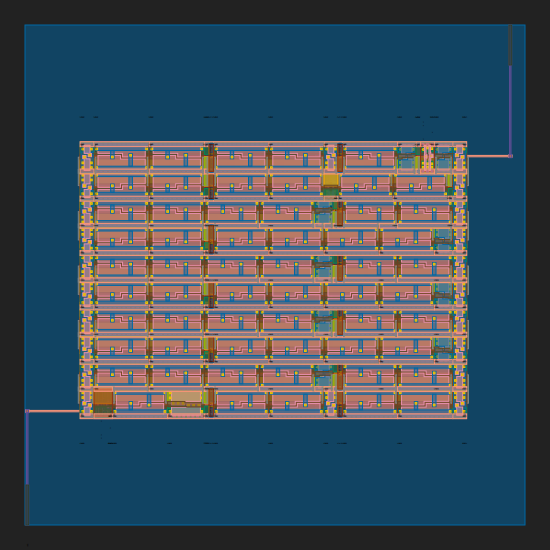

In [15]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('inverter.svg')
IPython.display.SVG('inverter.svg')

## Dump flow report

In [16]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
design,/home/proppy/src/github.com/chipsalliance/sili...
design_name,inverter
config,RUN_2022.06.03_22.59.18
flow_status,flow completed
total_runtime,0h0m18s0ms
routed_runtime,0h0m10s0ms
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.0025
CellPer_mm^2,-1
OpenDP_Util,-1
